In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import pathlib

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
print(tf.__version__)

2.6.0


In [4]:
data_dir = pathlib.Path("/home/divyanshu/Documents/Datasets/Traffic signal recognition/Train")

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

39209


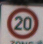

In [6]:
sign0 = list(data_dir.glob('0/*'))
PIL.Image.open(str(sign0[29]))

In [7]:
batch_size= 32
img_height= 64
img_width= 64

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


2021-08-17 01:47:32.133372: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


2021-08-17 01:47:37.276677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


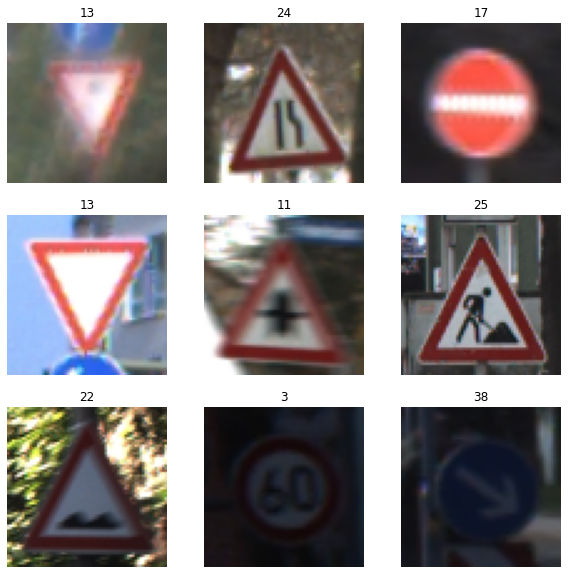

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32,)


In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = 43

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid"),
  #layers.Dropout(0.1),
  layers.Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid"),
  layers.Dropout(0.7),
  layers.Flatten(),
  layers.Dense(120, activation='relu'),
  layers.Dense(84, activation='relu'),
  layers.Dense(num_classes, activation= 'softmax')
])


In [16]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 60, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0

In [18]:
history= model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8


/home/divyanshu/tfenv/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


981/981 [==============================] - 383s 390ms/step - loss: 1.3417 - accuracy: 0.6124 - val_loss: 0.3572 - val_accuracy: 0.9045
Epoch 2/8
197/981 [=====>........................] - ETA: 42s - loss: 0.5882 - accuracy: 0.8261

KeyboardInterrupt: 

In [ ]:
epochs=8
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
img_path=pathlib.Path("/home/divyanshu/Documents/Datasets/Traffic signal recognition/Test/test_ds/02521.png")
img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = predictions[0]
plt.imshow(img)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
